In [1]:
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader, Subset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm import tqdm

In [2]:
class MovieReviewDataset(Dataset):
    def __init__(self, data, labels, tokenizer):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return input_ids, attention_mask, label

In [3]:
class DistilBertModelForRegression(nn.Module):
    def __init__(self, output_dim, dropout_rate=0.2):
        super(DistilBertModelForRegression, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.distilbert.config.hidden_size, output_dim)

        # Freeze the DistilBERT layers
        for param in self.distilbert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        dropped_output = self.dropout(pooled_output)
        output = self.fc(dropped_output)
        return output

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

# Set hyperparameters
batch_size = 16
learning_rate = 1e-5

Device:  cuda


In [5]:
# Load and preprocess the dataset
def load_dataset(root_dir):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        label_dir = os.path.join(root_dir, label)
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                data.append(text)
                rating = int(filename.split('_')[-1].split('.')[0])
                normalized_rating = (rating - 1) / 9.0
                labels.append(normalized_rating)
    return data, labels

train_dir = 'aclImdb/train'
test_dir = 'aclImdb/test'
tokenizer = get_tokenizer('basic_english')

train_data, train_labels = load_dataset(train_dir)
test_data, test_labels = load_dataset(test_dir)

In [6]:
def collate_fn(batch):
    input_ids, attention_masks, labels = zip(*batch)
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_dataset = MovieReviewDataset(train_data, train_labels, tokenizer)
test_dataset = MovieReviewDataset(test_data, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
# Initialize the model
model = DistilBertModelForRegression(1).to(device)

# Unfreeze the DistilBERT layers
for param in model.distilbert.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Set up directories
print("Creating necessary directories...")
model_name = 'bert1'
plot_dir = os.path.join(model_name, 'plots')
checkpoint_dir = os.path.join(model_name, 'checkpoints')
checkpoint_path = os.path.join(checkpoint_dir, 'latest.pt')
info_dir = os.path.join(model_name, 'info')
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(info_dir, exist_ok=True)
loss_plot_path = os.path.join(plot_dir, 'training_validation_loss.png')
checkpoint_increment = 20

# Load saved state dictionaries if they exist
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    print(f"Loaded checkpoint from epoch {start_epoch}")
else:
    start_epoch = 0
    file_path = os.path.join(info_dir, 'architecture.txt')
    model_info = str(model)
    with open(file_path, 'w') as file:
        file.write(model_info)
    print(f"Model architecture saved to {file_path}")
    train_losses = []
    test_losses = []
    
print('Starting the training...')
try:
    epoch = start_epoch
    while True:
        model.train()
        train_loss = 0.0

        for input_ids, attention_masks, targets in train_loader:
            input_ids, attention_masks, targets = input_ids.to(device), attention_masks.to(device), targets.to(device).float()

            optimizer.zero_grad()
            outputs = model(input_ids, attention_masks).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * input_ids.size(0)

        train_loss /= len(train_dataset)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for input_ids, attention_masks, targets in test_loader:
                input_ids, attention_masks, targets = input_ids.to(device), attention_masks.to(device), targets.to(device).float()
                outputs = model(input_ids, attention_masks).squeeze()
                loss = criterion(outputs, targets)
                test_loss += loss.item() * input_ids.size(0)


        test_loss /= len(test_dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}], Train Loss: {train_loss:.10f}, Test Loss: {test_loss:.10f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses
        }, checkpoint_path)
        
        if (epoch + 1) % checkpoint_increment == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'test_losses': test_losses
            }, os.path.join(checkpoint_dir, f'checkpoint{epoch + 1}.pt'))

        # Plotting and saving the figure
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(loss_plot_path)
        plt.close()

        epoch += 1

except KeyboardInterrupt:
    print('Training has been manually interrupted.')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Creating necessary directories...
Loaded checkpoint from epoch 20
Starting the training...
Epoch [21], Train Loss: 0.0265918329, Test Loss: 0.0313461476
Epoch [22], Train Loss: 0.0177048953, Test Loss: 0.0345309102
Epoch [23], Train Loss: 0.0140476970, Test Loss: 0.0348834710
Epoch [24], Train Loss: 0.0115702168, Test Loss: 0.0313130077
Epoch [25], Train Loss: 0.0100619241, Test Loss: 0.0316993784
Epoch [26], Train Loss: 0.0086063671, Test Loss: 0.0323832487
Epoch [27], Train Loss: 0.0077188767, Test Loss: 0.0307865831
Epoch [28], Train Loss: 0.0065898047, Test Loss: 0.0316293176
Epoch [29], Train Loss: 0.0058845946, Test Loss: 0.0300729335
Epoch [30], Train Loss: 0.0054141429, Test Loss: 0.0303616269
Epoch [31], Train Loss: 0.0047057829, Test Loss: 0.0318327033
Epoch [32], Train Loss: 0.0042862902, Test Loss: 0.0323805016
Epoch [33], Train Loss: 0.0039743681, Test Loss: 0.0309915983
Epoch [34], Train Loss: 0.0036568473, Test Loss: 0.0297402085
Epoch [35], Train Loss: 0.0034129132, Tes

In [7]:
model = DistilBertModelForRegression(output_dim=1).to(device)

checkpoint_path = 'bert1/checkpoints/checkpoint20.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModelForRegression(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
        

In [8]:
file_path = './example.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read().strip()

# Encode the text into input IDs and attention masks
inputs = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():  # Disable gradient calculation for inference
    prediction = model(input_ids=input_ids, attention_mask=attention_mask)
    predicted_value = prediction.cpu().squeeze().item()  # Convert to a single number if output_dim=1


print('Review content:')
print(text)
print('Predicted rating:')
print(predicted_value)

Review content:
Road House is exactly what it needs to be. A self-serious yet simultaneously very silly modern day riff on the Western that's packed with testosterone, crunchy action and jokes in the most unexpected places. It feels like a streaming movie in some distracting ways but it still remains one of the better ones.

Jake Gyllenhaal brings a natural intensity to Dalton as well as an impressive physical commitment. It's the possibility of his rage that he always keeps at bay that makes him so watchable in this role as he beats up his enemies and then makes sure they're okay before actually driving them to the hospital.

From the moment he's introduced, Conor McGregor is definitely something. It's the kind of performance that's never boring and never good. Every single line is delivered in hilariously awful fashion and yet he's one of the best parts of the film as he takes a very generically unhinged villain and makes it his own.

Doug Liman's direction certainly has a lot of ene

In [10]:
predicted = np.array([0.4467226266860962, 0.08403376489877701, 0.12596894800662994, 0.6068335175514221, 0.06321012228727341, 0.8133183717727661])
true = np.array([5, 4, 2, 4, 3, 7])

predicted = predicted * 9 + 1

print(predicted.mean(), true.mean())

4.210131026804447 4.166666666666667


In [104]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure the model is in evaluation mode
model.eval()

# Assuming test_data and test_labels are your full test datasets
num_samples = len(test_data)  # total number of samples in the test dataset
indices = np.arange(num_samples)  # create an array of indices corresponding to the test_data

# Shuffle the indices
np.random.shuffle(indices)

# Now take a subset of shuffled indices
subset_indices = indices[:1000]

# Create the subset using the shuffled indices
test_dataset_subset = MovieReviewDataset(np.array(test_data)[subset_indices].tolist(),
                                         np.array(test_labels)[subset_indices].tolist(),
                                         tokenizer)
test_subset_loader = DataLoader(test_dataset_subset, batch_size=2, collate_fn=collate_fn, shuffle=True)

# Collect all predictions and actual labels
predictions = []
true_labels = []

# Evaluate the model without gradient calculation
with torch.no_grad():
    for input_ids, attention_masks, targets in tqdm(test_subset_loader, desc='Evaluating Model', leave=True):
        input_ids, attention_masks, targets = input_ids.to(device), attention_masks.to(device), targets.to(device)
        outputs = model(input_ids, attention_masks).squeeze()
        # Append batch predictions and labels to the lists
        predictions.extend(outputs.cpu().numpy().tolist())
        true_labels.extend(targets.cpu().numpy().tolist())

Evaluating Model: 100%|████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.20it/s]


In [85]:
len(test_data)

25000

Mean Squared Error on Test Set: 0.03173732937181722
Mean Error on Test Set: 0.04560899379663169
R^2 Score on Test Set: 0.7903112353830944


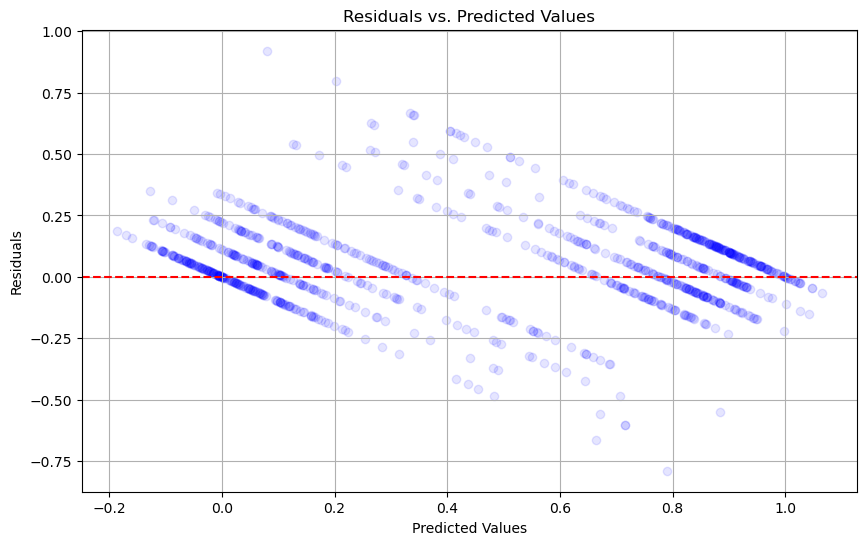

In [105]:
# Compute error metrics
mse = mean_squared_error(true_labels, predictions)
mean_error = (np.asarray(true_labels) - np.asarray(predictions)).sum() / len(true_labels)
r2 = r2_score(true_labels, predictions)

# Print the error metrics
print("Mean Squared Error on Test Set:", mse)
print("Mean Error on Test Set:", mean_error)
print("R^2 Score on Test Set:", r2)

# Plotting residuals
residuals = np.array(true_labels) - np.array(predictions)
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, color='blue', alpha=0.1)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()